Created June 6, 2025. \
Last revised June 16, 2025.

# Grism sim w/variable, wavelength-dependent PSF

This notebook is intended as a tutorial for the current state of Roman Grism Simulations using wavelength-dependent PSFs. All functions will be defined locally with comments pointing to files containing these functions, with the exception of roman_coords_transform, which is imported from observing-program/py for brevity (it's like 1000 lines long).

## Imports and function definitions
This section includes import cells and cells with function definitions.

In [34]:
from tqdm import tqdm
import h5py
import numpy as np
from scipy import signal
from astropy.io import fits
from astropy.table import Table
# from astropy.wcs import WCS
# from astropy import units as u
# from astropy.coordinates import SkyCoord
import os, sys
import pysynphot as S

from grizli.model import GrismFLT
import grizli.fake_image # linting software highlighting this as unused is mistaken; see cell 10 lines 14 & 15; DO NOT REMOVE

import pysiaf
import image_utils as iu
import psf_grid_utils as pgu

import yaml
import json
import hashlib

try:
    import stpsf
except:
    import webbpsf as stpsf

In [35]:
# This cell reads in environment variables.

github_dir=os.getenv('github_dir')
if github_dir is None:
    print('github_dir environment variable has not been set, will cause problems if not explicitly set in function calls')

psf_grid_data_read=os.getenv('psf_grid_data_read')
if psf_grid_data_read is None:
    print('psf_grid_data_read environment variable has not been set')

sys.path.append(github_dir+'/observing-program/py')
import roman_coords_transform as ctrans

In [36]:
# This cell mimics/copies from grism_sim/py/image_utils.py

wfi = stpsf.roman.WFI()
wfi.filter = "GRISM0" #eventually make this detector specific

def star_postage_grid(psf_grid, mag, detx=2044, dety=2044, fov_pixels=364):
    flux = mag2flux(mag)

    x_0 = int(detx)
    y_0 = int(dety)
    y, x = np.mgrid[y_0-fov_pixels:y_0+fov_pixels, x_0-fov_pixels:x_0+fov_pixels]

    psf = psf_grid.evaluate(x=x, y=y, x_0=detx, y_0=dety, flux=flux).astype(np.float32)
    return psf

def gal_postage_grid(psf_grid, detx=2044, dety=2044, fov_pixels=364, flux=1):

    x_0 = int(detx)
    y_0 = int(dety)
    y, x = np.mgrid[y_0-fov_pixels:y_0+fov_pixels, x_0-fov_pixels:x_0+fov_pixels]

    psf = psf_grid.evaluate(x=x, y=y, x_0=detx, y_0=dety, flux=flux)
    return psf

#fiducial zero point set based on 2022 sim below
def mag2flux(mag,zp=26.5):
    f0 = 10**(0.4*zp)
    flux = f0*10**(-0.4*mag) #mag = 26.5 - 2.5*np.log10(sumflux)
    return flux

def fake_header_wcs(crval1, crval2, crpix2=2044,crpix1=2044, cdelt1=0.11, cdelt2=0.11,
                crota2=0.0,naxis1=4088,naxis2=4088):
    #make empty hdu header and add wcs 
    
    hdu = fits.PrimaryHDU()
    
    return add_wcs(hdu,crval1, crval2, crpix2,crpix1, cdelt1, cdelt2, crota2,naxis1,naxis2)


def add_wcs(hdu,crval1, crval2, crpix2=2044,crpix1=2044, cdelt1=0.11, cdelt2=0.11,
                crota2=0.0,naxis1=4088,naxis2=4088):

    #add wcs to existing header
    #maintain consistency with https://github.com/roman-grs-pit/observing-program/blob/main/py/footprintutils.py, at some point make both use same function
    # crota2 - degree
    # cdelt1 - arcsec
    # cdelt2 - arcsec

    #hdu = fits.PrimaryHDU()
    #hdu.header

    # http://stsdas.stsci.edu/documents/SUG/UG_21.html

    theta = crota2*np.pi/180. # radians
    cdelt1 /= 3600. # deg
    cdelt2 /= 3600. # deg

    R = np.array([
        [-1*np.cos(theta), 1*np.sin(theta)],
        [1*np.sin(theta), np.cos(theta)],
    ])


    cd1_1 = cdelt1*R[0,0]
    cd1_2 = cdelt2*R[0,1]
    cd2_1 = cdelt1*R[1,0]
    cd2_2 = cdelt2*R[1,1]
                    
    hdu.header.set('NAXIS',2) # pixels
    hdu.header.set('NAXIS1',naxis1) # pixels
    hdu.header.set('NAXIS2',naxis2) # pixels

    hdu.header.set('WCSAXES',2) # pixels
    hdu.header.set('CTYPE1','RA---TAN')
    hdu.header.set('CTYPE2','DEC--TAN')
    hdu.header.set('CRVAL1',crval1) # deg
    hdu.header.set('CRVAL2',crval2) # deg
    hdu.header.set('CRPIX1',crpix1) # pixels
    hdu.header.set('CRPIX2',crpix2) # pixels
    #hdu.header.set('CDELT1',cdelt1)
    #hdu.header.set('CDELT2',cdelt2)
    #hdu.header.set('CROTA2',crota2)
    hdu.header.set("CD1_1",cd1_1)
    hdu.header.set("CD1_2",cd1_2)
    hdu.header.set("CD2_1",cd2_1)
    hdu.header.set("CD2_2",cd2_2)

    return hdu.header

In [37]:
# This cell mimics/copies from psf_grids/py/psf_grid_utils.py

def load_psf_grid(grid_file, psf_grid_data_read=psf_grid_data_read):
    """
    Reads in a saved GriddedPSFModel fits file. Returns that file.
    """
    filepath = os.path.join(psf_grid_data_read, grid_file)
    grid = stpsf.utils.to_griddedpsfmodel(filepath)
    return grid

def dict_hash(dict):
    """
    Return a SHA256 hash of a dictionary, order-independent.
    """

    # Convert dictionary to a JSON string with sorted keys
    dict_json = json.dumps(dict, sort_keys=True, separators=(',', ':'))
    # Encode and hash
    version_hash = hashlib.sha256(dict_json.encode('utf-8')).hexdigest()

    return version_hash

def check_version(filepath, ext=0, **kwargs):
    """
    Opens the fits located at {filepath}. Computes expected version_hash value from
    kwargs. Checks value against header. If values are equal, returns a 0. Else,
    prints header and returns a 1.
    """
    
    kwargs["stpsfver"] = stpsf.__version__
    expected_hash = dict_hash(kwargs)

    file = fits.open(filepath)
    header = file[ext].header

    if header["verhash"] == expected_hash:
        print(f"\nVersion hash matches expected value")
        return 0
    else:
        print(header.tostring(sep='\n'))
        print(f"\nVersion hash does not match")
        return 1

## Define the simulation parameters

With imports complete, environment variable read in, and helper functions defined, now we begin definind the sim. We start by created two catalogs with objects to simulate, one with stars, the other with galaxies. The, we define the telescope pointing, which detector to simulate, and where to save the output fits files.

This mimics the files in grism_sim/scripts which define these things and pass them into mk_grism and mk_ref_and_grism.

In [38]:
# For the purposes of this tutorial, we define the star catalog here in the notebook.

ind =   [0,       1]            # index
tmp =   [154.0,   154.0]        # star_template_index
mag =   [1.0,     1.0]          # magnitude
RA =    [9.4,     9.45]        # RA
DEC =   [1.05,   1.025]          # DEC

star_input = Table([ind, tmp, mag, RA, DEC],
               names=("index", "star_template_index", "magnitude", "RA", "DEC"))

# star_input = Table.read('/global/cfs/cdirs/m4943/grismsim/stars/sim_star_cat_galacticus.ecsv') 

In [39]:
# To run galaxies, you must have the right galaxy mocks in the mockdir. We will not assume that you have those and will set gal_input=None by default. 
# If you would like to simulate galaxies and have the neccessary files, uncomment lines at the end and change dogal to 'y'.

RA =    [9.43]
DEC =   [1.0]
SIM =   [23]
IDX =   [0]
Z =     [7.2]
mag_F158_Av1_6523 = [3.0]
unique_ID = [23]

gal_input = None

dogal='n'

# gal_input = Table([RA, DEC, SIM, IDX, Z, mag_F158_Av1_6523, unique_ID],
#                   names=("RA","DEC","SIM","IDX","Z","mag_F158_Av1.6523","unique_ID"))

# gal_input = Table.read('/global/cfs/cdirs/m4943/grismsim/galacticus_4deg2_mock/Euclid_Roman_4deg2_radec.fits')

In [40]:
# Define the telescope pointing

tel_ra = 9.5
tel_dec = 1
pa = 60
det_num = 1

# Which directory to save the fits in?

outdir = "/Users/keith/astr/research_astr/bin"

if len(outdir) == 0:
    raise Exception("You must specify where to save the fits files.")

# Other arguments typically passed into mk_grism
confver='03192025_rotAonly'     # Roman grism config file version
extra_grism_name=''             # This is appended to the grism fits filename 
gal_mag_col='mag_F158_Av1.6523' # Name of magnitude column in gal_inputs
magmax=25                       # Magnitude cutoff

mockdir = "/Users/keith/astr/research_astr/bin"

if len(mockdir) == 0:
    raise Exception("mockdir must point to a directory containing the Galacticus mocks. \
If using NERSC, set mockdir='/global/cfs/cdirs/m4943/grismsim/galacticus_4deg2_mock/'")

## Prepare fake fits files for Grizli

From here on, we're in the realm of grism_sim/py/grism_sim_psf_dependent.py and it's function mk_grism().

First, we load grizli_config.yaml. Then, we need to define our WCS. Next, we prepare fake fits files with proper headers. This gives Grizli the information it needs to function. 

In [41]:
# Read config file and Prepare WCS info

conf_file = os.path.join(github_dir, "grism_sim/data/grizli_config.yaml")
with open(conf_file) as f:
    grizli_conf = yaml.safe_load(f)

det = "SCA{:02}".format(det_num)
fov_pixels = grizli_conf["fov_pixels"]
gpad = grizli_conf["pad"]
tot_im_size = grizli_conf["detector_size"]+2*gpad 

In [42]:
siaf = pysiaf.Siaf("roman")
wfi_siaf = siaf["WFI{:02}_FULL".format(det_num)]
v2ref = siaf["WFI_CEN"].V2Ref
v3ref = siaf["WFI_CEN"].V3Ref

attmat = pysiaf.utils.rotations.attitude_matrix(v2ref, v3ref, tel_ra, tel_dec, pa)

wfi_siaf.set_attitude_matrix(attmat)

ra, dec = wfi_siaf.det_to_sky(2043, 2043)

In [43]:
# Prepare fits contents: Header info and empty/zero array

full_model = np.zeros((tot_im_size, tot_im_size))

background = grizli_conf["grism_background"]
EXPTIME = 301 
NEXP = 1

fn_root = 'refimage_ra%s_dec%s_pa%s_det%s' % (tel_ra,tel_dec,pa,det)
empty_direct_fits_out_nopad = os.path.join(outdir,fn_root+'_nopad.fits')

full_ref = np.zeros((tot_im_size, tot_im_size))
full_model = np.zeros((tot_im_size, tot_im_size))
phdu = fits.PrimaryHDU(data=full_model)
phdu.header["INSTRUME"] = 'ROMAN   '
phdu.header["FILTER"] = "f140w"
phdu.header["EXPTIME"] = 141
shp = full_model.shape
phdu.header = iu.add_wcs(phdu,ra, dec, crpix2=shp[1]/2,crpix1=shp[0]/2,crota2=pa,naxis1=shp[0],naxis2=shp[1])

In [44]:
# Save fake fits

err = np.random.poisson(10,full_model.shape)*0.001 #np.zeros(full_model.shape)
ihdu = fits.ImageHDU(data=full_model,name='SCI',header=phdu.header)
ehdu = fits.ImageHDU(data=err,name='ERR',header=phdu.header)
dhdu = fits.ImageHDU(data=np.zeros(full_model.shape),name='DQ',header=phdu.header)
hdul = fits.HDUList([phdu,ihdu,ehdu,dhdu])
hdul.writeto(empty_direct_fits_out_nopad, overwrite=True)

# Save empty grism fits
fn_root_grism = 'grism_ra%s_dec%s_pa%s_det%s' % (tel_ra,tel_dec,pa,det)
fn_root_grism += extra_grism_name 
empty_grism = os.path.join(outdir, 'empty_'+fn_root_grism+'.fits')
h, _ = grizli.fake_image.roman_header(ra=ra, dec=dec, pa_aper=pa, naxis=(4088,4088))
grizli.fake_image.make_fake_image(h, output=empty_grism, exptime=EXPTIME, nexp=NEXP, background=background)
file = fits.open(empty_grism)
file[1].header["CONFFILE"] = os.path.join(github_dir, "grism_sim/data/Roman.det"+str(det_num)+"."+confver+".conf") #% (det_num,confver))
file.writeto(empty_grism, overwrite=True)
file.close()

## Prepare object catalogs

We need to convert the catalogs from RA & DEC to detector coordinates. Then, we can cut the catalogs to only include objects which are on the detector for our pointing.

In [45]:
# Star RA/DEC -> detector coords
star_xy_siaf = wfi_siaf.sky_to_sci(star_input["RA"], star_input["DEC"])
star_xy = (star_xy_siaf[0]+gpad, star_xy_siaf[1]+gpad)

In [46]:
# Star cuts
sel_ondet = star_xy[0] > 0#stars00['Xpos'] < 4088 + 2*( gpad) #we want everything within padded area around grism
sel_ondet &= star_xy[0] < 4088 + 2*( gpad)
sel_ondet &= star_xy[1] > 0#stars00['Xpos'] < 4088 + 2*( gpad) #we want everything within padded area around grism
sel_ondet &= star_xy[1] < 4088 + 2*( gpad)

print('cutting stars to be on detector + padded area')
stars = star_input[sel_ondet]
stars['Xpos'] = star_xy[0][sel_ondet]
stars['Ypos'] = star_xy[1][sel_ondet]

cutting stars to be on detector + padded area


In [47]:
# Galaxy RA/DEC -> detector coords
if dogal == 'y':
    gal_xy_siaf = wfi_siaf.sky_to_sci(gal_input["RA"], gal_input["DEC"])
    gal_xy = (gal_xy_siaf[0] + gpad, gal_xy_siaf[1] + gpad)

In [48]:
# On-detector galaxy cuts
ngal = 0
if dogal == 'y':
    sel_ondet = gal_xy[0] > 0
    sel_ondet &= gal_xy[0] < 4088 + 2*( gpad)
    sel_ondet &= gal_xy[1] > 0
    sel_ondet &= gal_xy[1] < 4088 + 2*( gpad)
    gals = Table(gal_input[sel_ondet])
    gals['Xpos'] = gal_xy[0][sel_ondet]
    gals['Ypos'] = gal_xy[1][sel_ondet]
    gals.rename_column(gal_mag_col, 'mag')
    sel_mag = gals['mag'] < magmax
    gals = gals[sel_mag]
    ngal = len(gals)
    print('number of galaxies within detector padded region is '+str(ngal))

    #fiducial galaxy profile
    
    r_eff = 2.5 #radius for profile in pixels
    x, y = np.meshgrid(np.arange(-15,15), np.arange(-15,15)) #30x30 grid of pixels
    from astropy.modeling.models import Sersic2D
    round_exp = Sersic2D(amplitude=1, r_eff=r_eff,n=1) #round exponential 
    testprof = round_exp(x,y) #np.ones((4,4)) #just something that is not a pointsource, this should get much better
    testprof /= np.sum(testprof) #normalize the profile

## Read bandpass file, setup apodization, and instantiate grizli

We need to read in one more file, and setup a few more variable which will used within our long for-loop. Finally, we'll instantiate Grizli.

In [49]:
# Load bandpass file, read config file info, and define star template indicies
df = Table.read(os.path.join(github_dir, 'grism_sim/data/wfirst_wfi_f158_001_syn.fits'), format='fits') #close to H-band
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

tempdir = os.path.join(github_dir, 'star_fields/data/SEDtemplates/')
templates = open(os.path.join(github_dir, 'star_fields/data/SEDtemplates/input_spectral_STARS.lis')).readlines()
temp_inds = stars['star_template_index'] - 58*(stars['star_template_index']//58)

In [50]:
# Setup roll-on/roll-off shape
spectrum_overlap = grizli_conf["spectrum_overlap"]
window_x = np.linspace(0, np.pi, spectrum_overlap)
front_y = (1 - np.cos(window_x)) / 2
back_y = 1 - front_y

# This roll-on/roll-off allows Grizli to smoothly transition from one segment of the dispersion to the next. 
# Grizli's dispersion relies on FFT. So, without this apodizing, the ends of each dispersion get weird.

In [51]:
# Define resolution of the wavelength-dependence of the PSF
# more psfs is generally smoother, but the compute-time scales roughly linearly

minlam = grizli_conf["minlam"]
maxlam = grizli_conf["maxlam"]
npsfs = grizli_conf["npsfs"]

bins = np.linspace(minlam, maxlam, npsfs + 1)

psf_kwargs = None

In [52]:
# Check that the required PSF grids exist

for start_wave in bins[:-1]:
    
    psf_filename = f"wfi_grism0_fovp364_wave{start_wave:.0f}_{det}.fits".lower() # {instrument}_{filter}_{fovp}_wave{wavelength}_{det}.fits
    print(f"Checking {psf_filename}")

    try:
        psf_grid = pgu.load_psf_grid(psf_filename)

    except OSError as e:
        print(f"\nPSF Grid fits file not found. Check wavelength bins. If needed, use psf_grids to generate new grids. \n")
        raise e

    psf_fp = os.path.join(psf_grid_data_read, psf_filename)
    if psf_kwargs is not None:
        pgu.check_version(psf_fp, **psf_kwargs)
    else:
        pgu.check_version(psf_fp)


Checking wfi_grism0_fovp364_wave10000_sca01.fits
Version hash matches expected value
Checking wfi_grism0_fovp364_wave10500_sca01.fits
Version hash matches expected value
Checking wfi_grism0_fovp364_wave11000_sca01.fits
Version hash matches expected value
Checking wfi_grism0_fovp364_wave11500_sca01.fits
Version hash matches expected value
Checking wfi_grism0_fovp364_wave12000_sca01.fits
Version hash matches expected value
Checking wfi_grism0_fovp364_wave12500_sca01.fits
Version hash matches expected value
Checking wfi_grism0_fovp364_wave13000_sca01.fits
Version hash matches expected value
Checking wfi_grism0_fovp364_wave13500_sca01.fits
Version hash matches expected value
Checking wfi_grism0_fovp364_wave14000_sca01.fits
Version hash matches expected value
Checking wfi_grism0_fovp364_wave14500_sca01.fits
Version hash matches expected value
Checking wfi_grism0_fovp364_wave15000_sca01.fits
Version hash matches expected value
Checking wfi_grism0_fovp364_wave15500_sca01.fits
Version hash mat

In [53]:
# Instantiate Grizli GrismFLT object
size = grizli_conf["size"][det]
thresh = 0.01

# Instantiate Grizli GrizliFLT
roman = GrismFLT(grism_file=empty_grism,ref_file=empty_direct_fits_out_nopad, seg_file=None, pad=gpad) 
roman.seg = np.zeros((tot_im_size,tot_im_size), dtype=np.float32)

Image cutout: x=slice(0, 6088, None), y=slice(0, 6088, None) [Out of range]
/Users/keith/astr/research_astr/bin/empty_grism_ra9.5_dec1_pa60_detSCA01.fits / blot reference /Users/keith/astr/research_astr/bin/refimage_ra9.5_dec1_pa60_detSCA01_nopad.fits[0]
Using default C-based coordinate transformation...


## Run the simulation

This can be seperated into a few parts: load psf grid, place object on the direct image and segmentation map, call grizli to disperse. These happen in a loop over 20 wavelengths. The second two, placing the object and calling grizli, happen in another loop over every object in the catalogs.

In [54]:
# for-loop iterating over wavelength segments
    # define spectrum segment limits
    # read psf grid
    # for-loop iterating over objects (stars & galaxies)
        # place object
        # Grizli sim
        # Save to full_model

for ii, start_wave in enumerate(bins[:-1]):
    end_wave = bins[ii+1]
    print(f"starting at {start_wave}")

    psf_filename = f"wfi_grism0_fovp364_wave{start_wave:.0f}_{det}.fits".lower() # {instrument}_{filter}_{fovp}_wave{wavelength}_{det}.fits
    psf_grid = pgu.load_psf_grid(psf_filename)

    # STAR SIM
    print("adding stars to model")
    for i in tqdm(range(0,len(stars))):
        photid = i+1

        # STAR DIRECT
        # direct read of characteristics
        xpos = stars[i]['Xpos']
        ypos = stars[i]['Ypos']
        mag = stars[i]['magnitude']

        # cleaned up characteristisc
        xp = int(xpos) 
        yp = int(ypos)
        xtrue = xpos - gpad
        ytrue = ypos - gpad

        sp = iu.star_postage_grid(psf_grid,mag,xtrue,ytrue,fov_pixels=fov_pixels) # PSF from grid

        # sp limits are needed to keep only what fits on the detector (plus pad)
        sp_lims = [max(0,-(yp-fov_pixels)), min(fov_pixels*2,fov_pixels*2-(yp+fov_pixels-tot_im_size)),
                    max(0,-(xp-fov_pixels)), min(fov_pixels*2,fov_pixels*2-(xp+fov_pixels-tot_im_size))]

        roman_lims = [max(0, yp-fov_pixels), min(tot_im_size, yp+fov_pixels), 
                        max(0, xp-fov_pixels), min(tot_im_size, xp+fov_pixels)]

        # Set direct image equal to sp; don't add
        roman.direct.data["REF"][roman_lims[0]:roman_lims[1], roman_lims[2]:roman_lims[3]] = sp[sp_lims[0]:sp_lims[1],sp_lims[2]:sp_lims[3]]
        roman.direct.data['REF'] *= roman.direct.ref_photflam 

        if start_wave==minlam:
            full_ref[roman_lims[0]:roman_lims[1], roman_lims[2]:roman_lims[3]] += sp[sp_lims[0]:sp_lims[1],sp_lims[2]:sp_lims[3]]

        # Define selseg from original sp
        selseg = sp[sp_lims[0]:sp_lims[1],sp_lims[2]:sp_lims[3]] > thresh
        # set seg; use unique ids to make other spaces irrelevant (no need to reset between stars)
        roman.seg[roman_lims[0]:roman_lims[1], roman_lims[2]:roman_lims[3]][selseg] = photid 

        # Rotations after placement on detector
        roman.direct.data["REF"] = np.rot90(roman.direct.data["REF"], k=3)
        roman.seg = np.rot90(roman.seg, k=3)

        # STAR GRISM
        row = stars[i]
        mag = row["magnitude"]
        temp_ind = int(temp_inds[i])
        #print(temp_ind)
        star_type = templates[temp_ind].strip('\n')
        temp = np.loadtxt(os.path.join(tempdir, star_type)).transpose()
        wave = temp[0]
        flux = temp[1]

        # renormalization has to occur before picking out the spectrum segment to avoid a DisjointError
        star_spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstroms", fluxunits="flam")
        spec = star_spec.renorm(mag, "abmag", bp)
        spec.convert("flam")

        # if-elses enforce minlam/maxlam bounds on the spectrum (and avoid issues with negative indicies)
        if start_wave != minlam:
            # Adjust start_wave to include overlap region
            start_wave_index = np.searchsorted(spec.wave, start_wave, side="left")
            start_index_w_overlap = start_wave_index - int(spectrum_overlap * 0.5)
            sel = wave >= spec.wave[start_index_w_overlap]
        else:
            # Set lower limit on sel_wave
            sel = wave >= start_wave

        if end_wave != maxlam:
            # Adjust end_wave to include overlap region
            end_wave_index = np.searchsorted(spec.wave, end_wave, side="right")
            end_index_w_overlap = end_wave_index + int(spectrum_overlap * 0.5 - 1) 
            sel &= wave < spec.wave[end_index_w_overlap]
        else:
            # Set upper limit on sel_wave
            sel &= wave <= end_wave
        
        # pick out segment of spectrum
        wave = spec.wave[sel]
        flux = spec.flux[sel]

        # apodize/roll-on, roll-off
        if start_wave != minlam:
            flux[:spectrum_overlap] *= front_y
        if end_wave != maxlam:
            flux[-spectrum_overlap:] *= back_y            
        
        segment_of_dispersion = roman.compute_model_orders(id=photid, mag=mag, compute_size=False, size=size, in_place=False, store=False,
                                is_cgs=True, spectrum_1d=[wave, flux])
        
        # compute_model_orders returns a boolean IF the dispersion would not land on the detector
        try:
            full_model += segment_of_dispersion[1]
        except TypeError: # catch "cannot index bool" error
            continue

    if ngal > 0:
        print('adding galaxies to model')
        for i in tqdm(range(0,ngal)):
            if "photid" not in locals():
                photid = 0
            photid += 1
            row = gals[i]

            # direct read of characteristics
            xpos = row['Xpos']
            ypos = row['Ypos']
            mag = row['mag']

            # cleaned up characteristisc
            xp = int(xpos) 
            yp = int(ypos)
            xtrue = xpos - gpad
            ytrue = ypos - gpad

            # make direct thumbnail and convolve with psf
            imflux = iu.mag2flux(mag)#imflux = row['flux']
            gal_psf = iu.gal_postage_grid(psf_grid,xtrue,ytrue,fov_pixels=fov_pixels)
            conv_prof = signal.convolve2d(gal_psf,testprof,mode='same') 
            sp = imflux*conv_prof

            # sp limits are needed to keep only what fits on the detector (plus pad)
            sp_lims = [max(0,-(yp-fov_pixels)), min(fov_pixels*2,fov_pixels*2-(yp+fov_pixels-tot_im_size)),
                        max(0,-(xp-fov_pixels)), min(fov_pixels*2,fov_pixels*2-(xp+fov_pixels-tot_im_size))]

            roman_lims = [max(0, yp-fov_pixels), min(tot_im_size, yp+fov_pixels), 
                            max(0, xp-fov_pixels), min(tot_im_size, xp+fov_pixels)]

            # Set direct image equal to sp; don't add
            roman.direct.data["REF"][roman_lims[0]:roman_lims[1], roman_lims[2]:roman_lims[3]] = sp[sp_lims[0]:sp_lims[1],sp_lims[2]:sp_lims[3]]
            roman.direct.data['REF'] *= roman.direct.ref_photflam

            if start_wave==minlam:
                full_ref[roman_lims[0]:roman_lims[1], roman_lims[2]:roman_lims[3]] += sp[sp_lims[0]:sp_lims[1],sp_lims[2]:sp_lims[3]]
            
            selseg = sp[sp_lims[0]:sp_lims[1],sp_lims[2]:sp_lims[3]] > thresh
            roman.seg[roman_lims[0]:roman_lims[1], roman_lims[2]:roman_lims[3]][selseg] = photid

            # Rotations after placement on detector
            roman.direct.data["REF"] = np.rot90(roman.direct.data["REF"], k=3)
            roman.seg = np.rot90(roman.seg, k=3)
            
            #get sed and convert to spectrum
            sim_fn = os.path.join(mockdir, 'galacticus_FOV_EVERY100_sub_'+str(row['SIM'])+'.hdf5')
            sim = h5py.File(sim_fn, 'r')
            sed_flux = sim['Outputs']['SED:observed:dust:Av1.6523'][row['IDX']]

            # initial cut to avoid errors from nan values
            wave = np.linspace(2000, 40000, 19001) #wavelength grid for simulation
            sel_wave = wave > minlam
            sel_wave &= wave < maxlam
            wave = wave[sel_wave]
            flux = sed_flux[sel_wave]
            
            gal_spec = S.ArraySpectrum(wave=wave, flux=flux, waveunits="angstroms", fluxunits="flam")
            spec = gal_spec.renorm(mag, "abmag", bp) # renorm and convert units
            spec.convert("flam") 

            # if-elses enforce minlam/maxlam bounds on the spectrum (and avoid issues with negative indicies)
            if start_wave != minlam:
                # Adjust start_wave to include overlap region
                start_wave_index = np.searchsorted(spec.wave, start_wave, side="left")
                start_index_w_overlap = start_wave_index - int(spectrum_overlap * 0.5)
                sel_wave = spec.wave >= spec.wave[start_index_w_overlap]
            else:
                # Set lower limit on sel_wave
                sel_wave = spec.wave >= start_wave

            if end_wave != maxlam:
                # Adjust end_wave to include overlap region
                end_wave_index = np.searchsorted(spec.wave, end_wave, side="right")
                end_index_w_overlap = end_wave_index + int(spectrum_overlap * 0.5 - 1) 
                sel_wave &= spec.wave < spec.wave[end_index_w_overlap]
            else:
                # Set upper limit on sel_wave
                sel_wave &= spec.wave <= end_wave

            # pick out segment of spectrum
            wave = spec.wave[sel_wave]
            flux = spec.flux[sel_wave]

            # apodize/roll-on, roll-off
            if start_wave != minlam:
                flux[:spectrum_overlap] *= front_y
            if end_wave != maxlam:
                flux[-spectrum_overlap:] *= back_y    

            segment_of_dispersion = roman.compute_model_orders(id=photid, mag=mag, compute_size=False, size=size, in_place=False, store=False,
                                    is_cgs=True, spectrum_1d=[wave, flux])
            
            # compute_model_orders returns a boolean IF the dispersion would not land on the detector
            try:
                full_model += segment_of_dispersion[1] # catch "cannot index bool" error
            except TypeError:
                continue

starting at 10000.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.23it/s]


starting at 10500.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.12it/s]


starting at 11000.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


starting at 11500.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


starting at 12000.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.04it/s]


starting at 12500.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


starting at 13000.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


starting at 13500.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.09it/s]


starting at 14000.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.08it/s]


starting at 14500.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


starting at 15000.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.13it/s]


starting at 15500.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


starting at 16000.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.18it/s]


starting at 16500.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


starting at 17000.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


starting at 17500.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


starting at 18000.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]


starting at 18500.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.25it/s]


starting at 19000.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


starting at 19500.0
adding stars to model


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


In [55]:
# Final model rotation

roman.model = np.rot90(full_model, k=1)

# Save model

hdu_list = fits.open(empty_grism)
if gpad != 0:
    hdu_list.append(fits.ImageHDU(data=roman.model[gpad:-gpad, gpad:-gpad],name='MODEL'))
    #hdu_list.append(fits.ImageHDU(data=roman.grism.data['SCI'][gpad:-gpad, gpad:-gpad],name='ERR'))
    hdu_list['ERR'].data = roman.grism.data['SCI'][gpad:-gpad, gpad:-gpad]
else:
    hdu_list.append(fits.ImageHDU(data=roman.model,name='MODEL'))
    #hdu_list.append(fits.ImageHDU(data=roman.grism.data['SCI']),name='ERR')
    hdu_list['ERR'].data = roman.grism.data['SCI']

out_fn = os.path.join(outdir, fn_root_grism+'.fits')
hdu_list.writeto(out_fn, overwrite=True)
hdu_list.close()
print('wrote to '+out_fn)

wrote to /Users/keith/astr/research_astr/bin/grism_ra9.5_dec1_pa60_detSCA01.fits


In [56]:
# Save reference direct image; note that this direct image uses a monochromatic PSF at 10000 Angstrom

hdu_list = fits.open(empty_direct_fits_out_nopad)
if gpad != 0:
    hdu_list.append(fits.ImageHDU(data=full_ref[gpad:-gpad, gpad:-gpad],name='IMAGE'))
else:
    hdu_list.append(fits.ImageHDU(data=full_ref,name='IMAGE'))

out_ref_fn = os.path.join(outdir, fn_root+'.fits')
hdu_list.writeto(out_ref_fn, overwrite=True)
hdu_list.close()
print('wrote to '+out_ref_fn)

wrote to /Users/keith/astr/research_astr/bin/refimage_ra9.5_dec1_pa60_detSCA01.fits


## Observe the result

At this point, the simulation is done. The next few cells are dedicated to reading in the results generated here and showing them in-notebook.

In [57]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["image.interpolation"] = "nearest"
mpl.rcParams["image.origin"] = "lower"
mpl.rcParams["figure.figsize"] = (15,15)

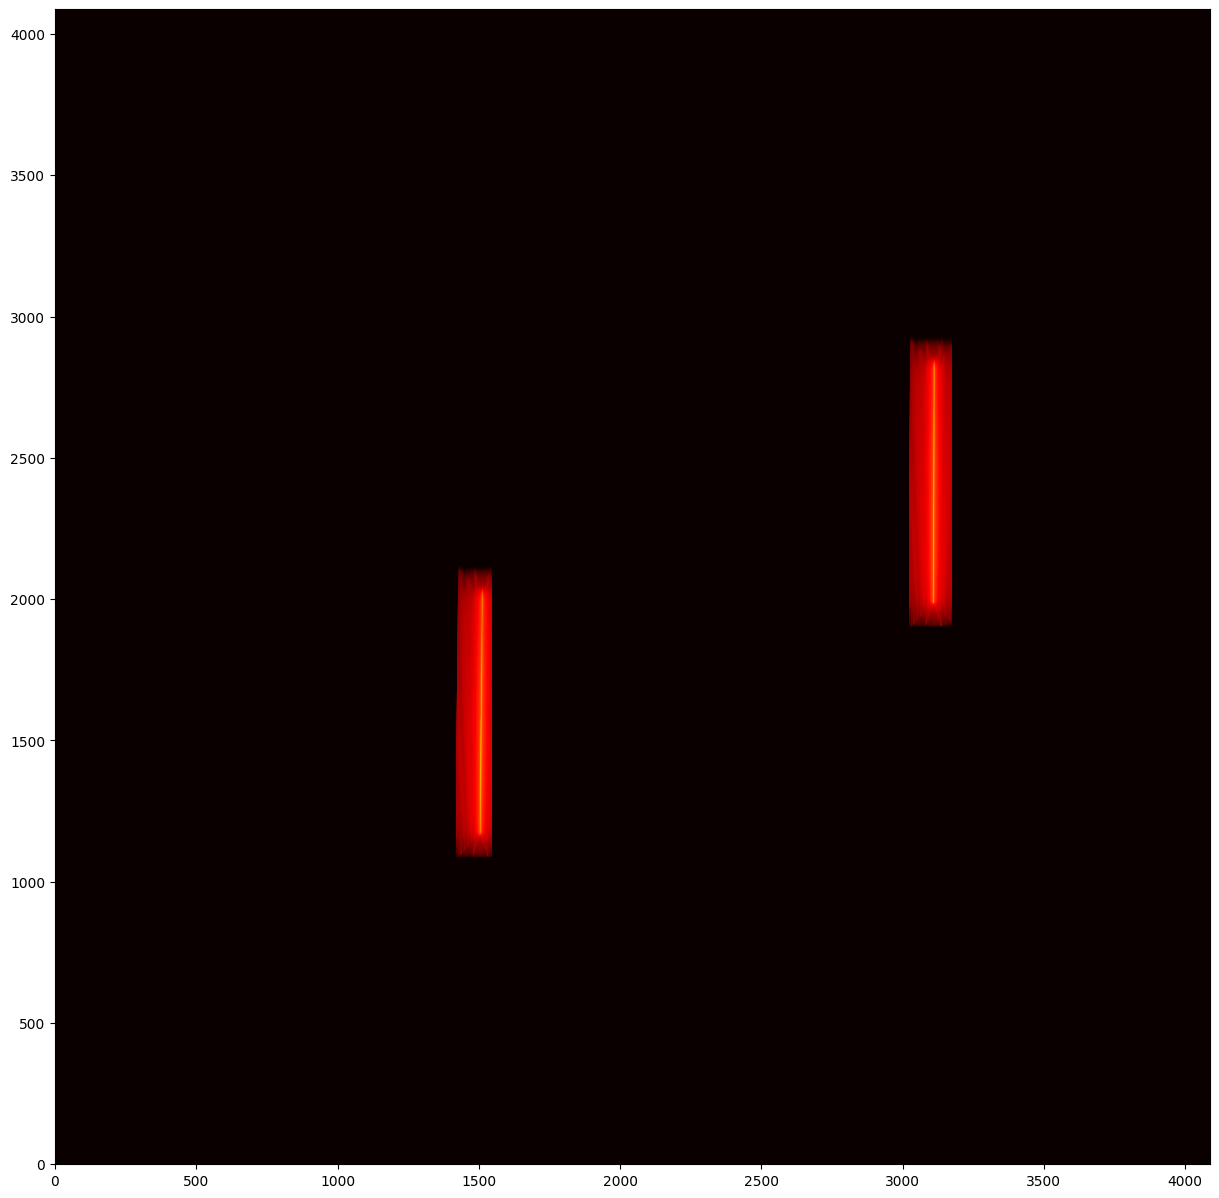

In [58]:
model_file = fits.open(out_fn)
model_data = model_file[4].data

plt.imshow(np.log(model_data+1), cmap="hot", vmin=0, vmax=27)

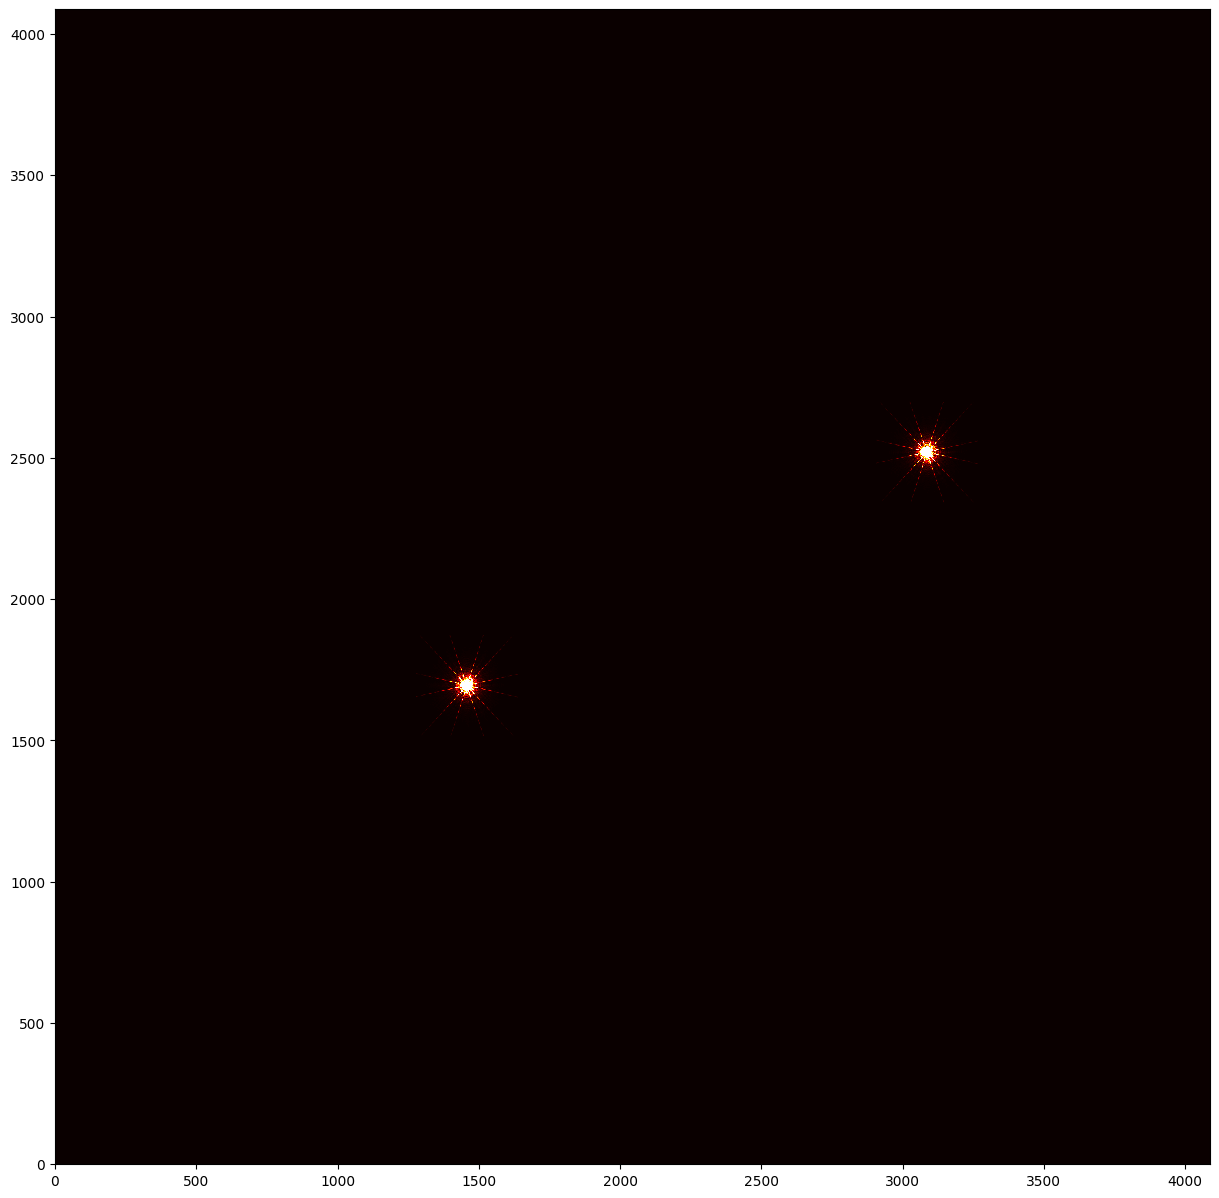

In [59]:
ref_file = fits.open(out_ref_fn)
ref_data = ref_file[4].data

plt.imshow(ref_data, cmap="hot", vmin=0, vmax=100000)